# GEQIE NAQSS Example

This is the example notebook that presents how to use GEQIE framework for encoding an image into its quantum representation using NAQSS method [(Li et al., 2014)](https://link.springer.com/article/10.1007/s11128-013-0705-7).

## Setup

### Imports

In [8]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
from itertools import product

In [2]:
import geqie
from geqie.encodings import naqss

### Helper Functions

In [3]:
def add_wire_grid(fig, xs, ys, zs, color="black", width=2, dash="dash"):
    # Each entry describes:
    # (axis_name, iterable1, iterable2, fixed_axis, range_min, range_max)
    axes = [
        ("x", ys, zs, "y,z", xs[0], xs[-1]),  # X-direction lines
        ("y", xs, zs, "x,z", ys[0], ys[-1]),  # Y-direction lines
        ("z", xs, ys, "x,y", zs[0], zs[-1]),  # Z-direction lines
    ]

    for axis, a1, a2, _, start, end in axes:
        for u, v in product(a1, a2):
            if axis == "x":
                x = [start, end]; y = [u, u];       z = [v, v]
            elif axis == "y":
                x = [u, u];       y = [start, end]; z = [v, v]
            else:  # axis == "z"
                x = [u, u];       y = [v, v];       z = [start, end]

            fig.add_trace(go.Scatter3d(
                x=x, y=y, z=z,
                mode="lines",
                line=dict(color=color, width=width, dash=dash),
                showlegend=False
            ))


def plot_3d_image(image, title="3D Image Visualization"):
    x, y, z = np.indices(image.shape)
    fig = go.Figure(data=go.Scatter3d(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        mode="markers+text",
        marker=dict(
            symbol="square",
            size=12,
            line=dict(color="black", width=2),
            color=image.flatten(),
            colorscale="Greys",
            cmin=0,
            cmax=255,
            colorbar=dict(
                title="Pixel Value", 
                tickvals=[0, 64, 128, 192, 255],
                ticktext=["0", "64", "128", "192", "255"]
            ),
        ),
        text=image.flatten(),
        textposition="top center",
        showlegend=False,
    ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(showbackground=False, dtick=1),
            yaxis=dict(showbackground=False, dtick=1),
            zaxis=dict(showbackground=False, dtick=1),
        ),
        scene_camera=dict(eye=dict(x=2, y=1, z=1)),
        margin=dict(l=0, r=0, b=20, t=40)
    )

    add_wire_grid(fig, x.flatten(), y.flatten(), z.flatten())

    return fig


## Encoding

### Displaying the image

Creating a test single-channel image $2 \times 2 \times 2$ and normalizing its pixel values to $[0.0, 1.0]$.

In [4]:
np.random.seed(0)
image = np.random.randint(0, 256, size=(2, 2, 2), dtype=np.uint8)

In [5]:
image

array([[[172,  10],
        [127, 140]],

       [[ 47, 170],
        [196, 151]]], dtype=uint8)

In [13]:
plot_3d_image(image, title="Visualization of the 2x2x2 image")

### Encoding using unitary gate

In [7]:
circuit = geqie.encode(naqss.init_function, naqss.data_function, naqss.map_function, image)
circuit.draw(output="text")

»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
   q_4: »
        »
meas: 5/»
        »
«        ┌──────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                             ├»
«        │                                                                              │»
«   q_1: ┤1                                                                             ├»
«        │                                                                              │»
«   q_2: ┤2 Initialize(1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) ├»
«        │                                                                              │»
«   q_3: ┤3                                                                             ├»
«        │                                                                              │»
«   q_4: ┤4                                                                             ├»
«        └──────────────────────────────────────────────────────────────────────────────┘»
«meas: 5/════════════════════════════════════════════════════════════════════════════════»
«                                                                                        »
«        ┌──────────┐ ░ ┌─┐            
«   q_0: ┤0         ├─░─┤M├────────────
«        │          │ ░ └╥┘┌─┐         
«   q_1: ┤1         ├─░──╫─┤M├─────────
«        │          │ ░  ║ └╥┘┌─┐      
«   q_2: ┤2 Unitary ├─░──╫──╫─┤M├──────
«        │          │ ░  ║  ║ └╥┘┌─┐   
«   q_3: ┤3         ├─░──╫──╫──╫─┤M├───
«        │          │ ░  ║  ║  ║ └╥┘┌─┐
«   q_4: ┤4         ├─░──╫──╫──╫──╫─┤M├
«        └──────────┘ ░  ║  ║  ║  ║ └╥┘
«meas: 5/════════════════╩══╩══╩══╩══╩═
«                        0  1  2  3  4

### Simulating the circuit

The stemplot represents the number of results for each possible quantum state of the system with decimal basis where, e.g., $\ket{13} \equiv \ket{01101}$.

Text(0, 0.5, 'n_results')

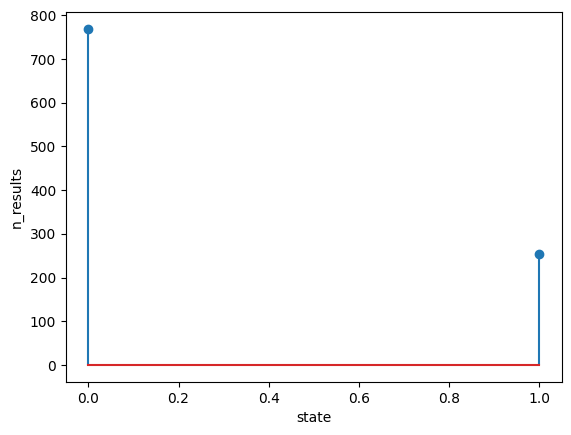

In [9]:
result = geqie.simulate(circuit, 1024)
plt.stem(result.values())
plt.xlabel("state")
plt.ylabel("n_results")

## Retrieving the image

In [ ]:
retrieved_image = naqss.retrieve_function(result, image.shape)
plot_3d_image(retrieved_image, title="Retrieved 3D Image from Quantum Circuit")

The color is encoded by the last qubit $c$, hence to retrieve the image one has to calculate the average number of resulting $c = \ket{1}$ for each pixel.

### Reconstructed image

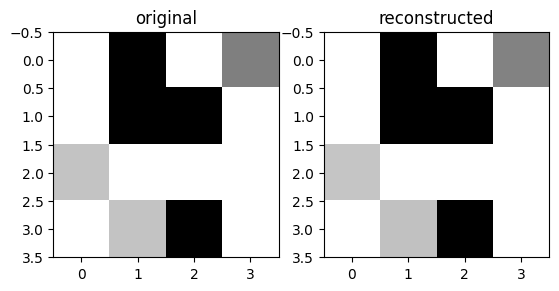

In [19]:
f = plt.figure()
gs = f.add_gridspec(1, 2)

ax = f.add_subplot(gs[0, 0])
ax.set_title("original")
ax.imshow(image, cmap="gray")

ax = f.add_subplot(gs[0, 1])
ax.set_title("reconstructed")
ax.imshow(retrieved_image, cmap="gray")

In [20]:
image

array([[255,   0, 255, 127],
       [255,   0,   0, 255],
       [195, 255, 255, 255],
       [255, 195,   0, 255]], dtype=uint8)

In [21]:
retrieved_image

array([[255,   0, 255, 130],
       [255,   0,   0, 255],
       [197, 255, 255, 255],
       [255, 193,   0, 255]], dtype=uint8)

In [22]:
%%!
255*2*retrieved_image/np.pi

["'255*2*retrieved_image' is not recognized as an internal or external command,",
 'operable program or batch file.']